In [1]:
# 케라스는 파이썬으로 작성된 오픈 소스 신경망 라이브러리다. 빠르게 딥러닝이 가능하도록 설계되어있으며 최소한의 제약사항으로 서로 연결된
# 모듈화를 지원한다. 신경망층, cost function, optimizer, initializer, normalization 모듈을 조합할 수 있다.

In [1]:
# 신경망 관련 4가지의 keras 모형
# (1) keras sequential model (첫번째)
from tensorflow import keras
import numpy as np
# import matplotlib
import matplotlib.pyplot as plt

In [2]:
# 먼저 엑셀 데이터를 가져와서 시계열 분석을 통해 pacf 를 알아본다.
# 참고로 가상환경 tensorflow 에서 기본 라이브러리가 설치되어있는지 확인하고 안되어있으면 직접 설치해주자
# anaconda cmd로 가서 conda activate 가상환경이름, pip install 라이브러리이름
import pandas as pd

In [19]:
load_filename = '농산물_수입량_수입가격.xlsx'
data1 = pd.read_excel(load_filename,index_col='날짜',sheet_name="전체") #날짜를 index로 처리하기위해
print(data1.head())

                 쌀_수입량        쌀_금액      팥_수입량     팥_금액      콩_수입량    콩_금액  \
날짜                                                                          
2012-01-01  17309411.0  14390615.0   484953.0   694428   621207.0  298470   
2012-02-01   7465279.0   6279896.0   607139.0   640202   532087.0  289048   
2012-03-01  22486603.0  18238124.0  3429365.0  3674904   894162.0  362021   
2012-04-01  22642156.0  19195746.0  2272238.0  2910072  1166611.0  539112   
2012-05-01  37076936.0  30108629.0  5993527.0  6158674  1127110.0  664481   

               녹두_수입량   녹두_금액    메밀_수입량   메밀_금액   기타콩_수입량  기타콩_금액  
날짜                                                                 
2012-01-01    46952.0   58548  223017.0   70110  335535.0  408319  
2012-02-01        0.0       0       0.0       0  140125.0  190148  
2012-03-01        0.0       0  120000.0   37680  247573.0  321311  
2012-04-01  1051500.0  977476  571566.0  350293  204449.0  271190  
2012-05-01    21201.0   23296  380000.0  216664  279

In [4]:
type(data1)

pandas.core.frame.DataFrame

In [ ]:
data1.info()

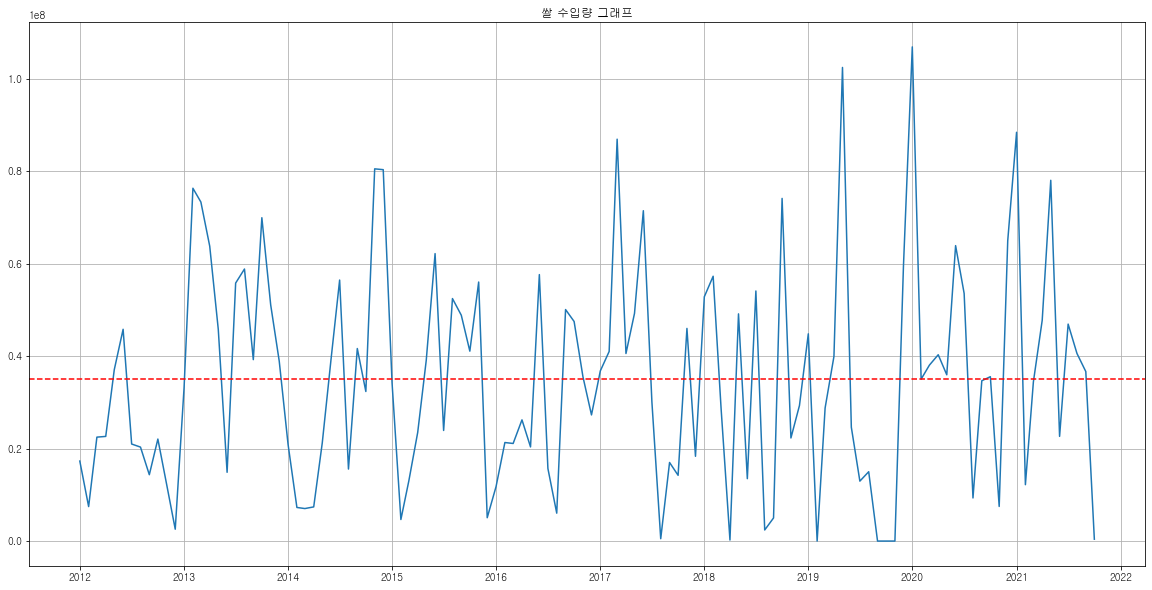

In [6]:
# 직접 그림을 그려본다.
# 경고문이 자주 떠서 방지하기 위해 다음과 같이 했습니다.
import warnings
from plotly.offline import init_notebook_mode, iplot # plotly 패키지 사용 --> for better plot
warnings.filterwarnings('ignore')

# 한글 깨짐 문제가 일어나면 아래와 같이 해결해준다
import matplotlib
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

matplotlib.rcParams['axes.unicode_minus']=False # 그래프에서 -기호가 깨지지 않게 하기위해

plt.figure(figsize=(20,10))
plt.title("쌀 수입량 그래프")
plt.plot(data1['쌀_수입량'],"-")
plt.grid()
plt.axhline(y= data1['쌀_수입량'].mean(), linestyle='--', color='red', label="mean")
plt.show()

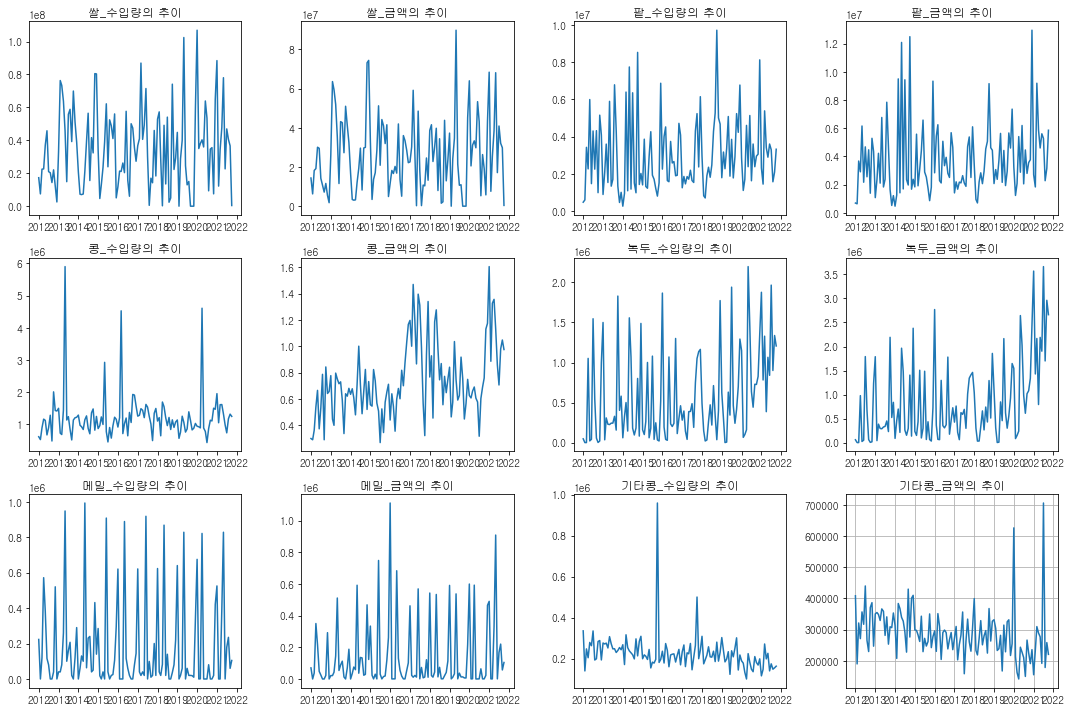

In [7]:
# 이제 한꺼번에 추이그래프를 나타내면
plt.figure(figsize=(15,10)) # 창을 먼저 만들고
n=1
for c in data1.columns[0:12]:
    ax = plt.subplot(3,4,n) # for문을 돌면서 axes 를 추가
    plt.title("%s의 추이" % c)
    ax.plot(data1[c],"-")
    n += 1
plt.tight_layout() # 창 크기에 맞게 조정
plt.grid()
plt.show()

In [8]:
data1.columns[0:12] # 변수들의 순서를 재확인해보자

Index(['쌀_수입량', '쌀_금액', '팥_수입량', '팥_금액', '콩_수입량', '콩_금액', '녹두_수입량', '녹두_금액',
       '메밀_수입량', '메밀_금액', '기타콩_수입량', '기타콩_금액'],
      dtype='object')

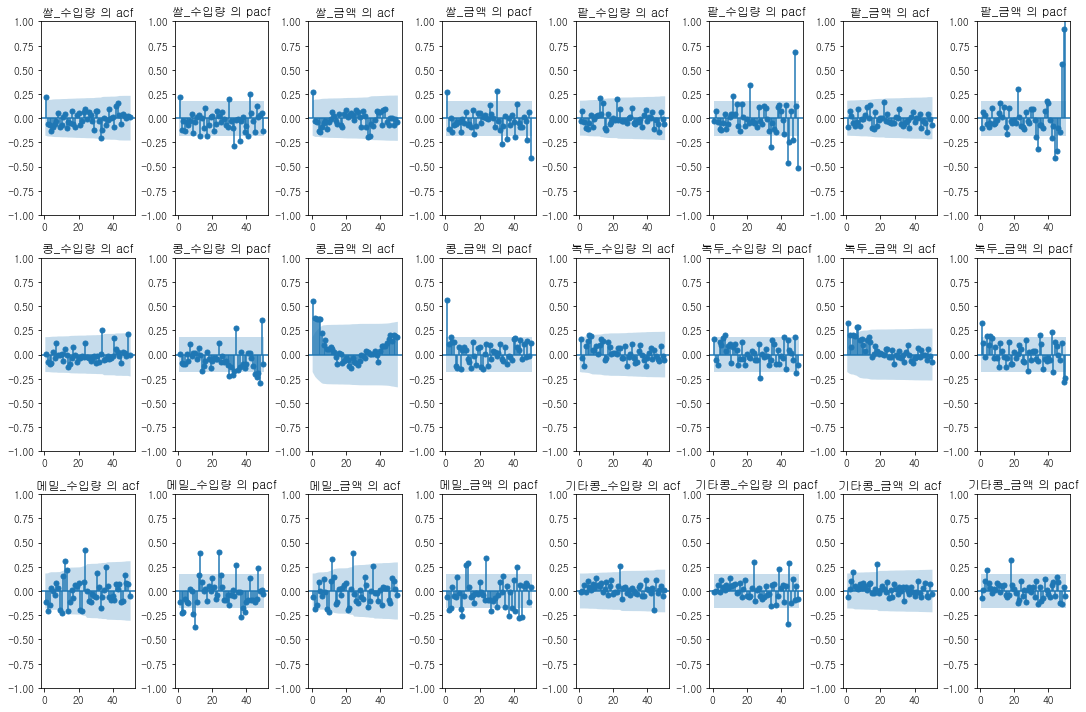

In [13]:
#이제 각각의 곡물에 대해서 pacf와 acf 를 그려보자.
import statsmodels.graphics.tsaplots as sgt
fig = plt.figure(figsize=(15,10))

nrow=3; ncol=8
#npanels = nrow*ncol

n=1
for c in data1.columns[0:12]:
    ax1 = fig.add_subplot(nrow,ncol,n)
    sgt.plot_acf(data1[c],lags=50, zero=False,ax=ax1) #시차 50까지 acf
    ax1.set_title("%s 의 acf" %c)
    ax2 = fig.add_subplot(nrow,ncol,n+1)
    sgt.plot_pacf(data1[c],lags=50, zero=False, ax=ax2) # 시차 50까지의 pacf
    ax2.set_title("%s 의 pacf" %c)
    n += 2
plt.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.87, wspace=0.35, hspace=0.25)
plt.tight_layout()
plt.show() 

모든 변수에 대해서 acf와 pacf를 확인해보니 대략 콩금액데이터만 자기상관이 존재해보인다. 

In [20]:
# 결측값부터 대체해준다. 일단 0-->NaN으로 바꿔준다.
data1['녹두_수입량'] = data1['녹두_수입량'].replace(0,np.nan)
data1['메밀_수입량'] = data1['메밀_수입량'].replace(0,np.nan)

# 각 열마다 Nan의 개수를 확인
for col in data1.columns:
    missing_rows = data1.loc[data1[col]==0].shape[0]
    print(col + ': '+ str(missing_rows))

쌀_수입량: 0
쌀_금액: 0
팥_수입량: 0
팥_금액: 0
콩_수입량: 0
콩_금액: 0
녹두_수입량: 0
녹두_금액: 2
메밀_수입량: 0
메밀_금액: 6
기타콩_수입량: 0
기타콩_금액: 0


In [21]:
# 결측값을 확인했으니 대체값으로 채워준다.
# 훈련데이터셋의 평균값으로 결측값을 대체해준다.

train = data1.loc[:'2020-04-01']
test = data1.loc['2020-05-01':]


data1['녹두_수입량'] = data1['녹두_수입량'].fillna(train['녹두_수입량'].mean())
data1['메밀_수입량'] = data1['메밀_수입량'].fillna(train['메밀_수입량'].mean())

In [12]:
data1.isnull().sum()

쌀_수입량      0
쌀_금액       0
팥_수입량      0
팥_금액       0
콩_수입량      0
콩_금액       0
녹두_수입량     0
녹두_금액      0
메밀_수입량     0
메밀_금액      0
기타콩_수입량    0
기타콩_금액     0
dtype: int64

결측값을 처리해주고 다시한번 acf와 pacf를 그렸는데도 비슷하게 나왔다.

In [31]:
volume_cols = ['쌀_수입량','팥_수입량','콩_수입량','녹두_수입량','메밀_수입량','기타콩_수입량']
volume = data1[volume_cols]

rice_col = ['쌀_수입량','쌀_금액']
rice = data1[rice_col]

redbean_col = ['팥_수입량','팥_금액']
redbean = data1[redbean_col]

bean_col = ['콩_수입량','콩_금액']
bean = data1[bean_col]

greengram_col = ['녹두_수입량','녹두_금액']
greengram = data1[greengram_col]

buckwheat_col = ['메밀_수입량','메밀_금액']
buckwheat = data1[buckwheat_col]

etcbean_col = ['기타콩_수입량','기타콩_금액']
etcbean = data1[etcbean_col]

#print(rice.head())
#print(rice.loc[:'2020-04-01'].values.reshape((100,2)))


rice_train = rice.loc[:'2020-04-01'].values.reshape((100,2))
rice_test = rice.loc['2020-05-01':].values.reshape((18,2))


redbean_train = redbean.loc[:'2020-04-01'].values.reshape((100,2))
redbean_test = redbean.loc['2020-05-01':].values.reshape((18,2))

bean_train = bean.loc[:'2020-04-01'].values.reshape((100,2))
bean_test = bean.loc['2020-05-01':].values.reshape((18,2))

greengram_train = greengram.loc[:'2020-04-01'].values.reshape((100,2))
greengram_test = greengram.loc['2020-05-01':].values.reshape((18,2))

buckwheat_train = buckwheat.loc[:'2020-04-01'].values.reshape((100,2))
buckwheat_test = buckwheat.loc['2020-05-01':].values.reshape((18,2))

etcbean_train = etcbean.loc[:'2020-04-01'].values.reshape((100,2))
etcbean_test = etcbean.loc['2020-05-01':].values.reshape((18,2))


In [30]:
type(rice_train) # array 반환이 되었다.

numpy.ndarray

In [38]:
# 정규화 과정을 거친다.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_rice_train = scaler.fit_transform(rice_train) #정규화 수행
scaled_rice_test = scaler.transform(rice_test)

scaled_redbean_train = scaler.fit_transform(redbean_train) 
scaled_redbean_test = scaler.transform(redbean_test)

scaled_bean_train = scaler.fit_transform(bean_train) 
scaled_bean_test = scaler.transform(bean_test)

scaled_greengram_train = scaler.fit_transform(greengram_train) 
scaled_greengram_test = scaler.transform(greengram_test)

scaled_buckwheat_train = scaler.fit_transform(buckwheat_train) 
scaled_buckwheat_test = scaler.transform(buckwheat_test)

scaled_etcbean_train = scaler.fit_transform(etcbean_train) 
scaled_etcbean_test = scaler.transform(etcbean_test)
# 결과는 array



In [42]:
# 시계열데이터 형태 변환해주기--> 지도학습 데이터 구조로 바꿔준다#
#from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
#rice_volume = feature_df[0]
#redbean_volume = feature_df[1]
#bean_volume = feature_df[2]
#mungbean_volume = feature_df[3]
#buckwheat_volume = feature_df[4]
#etcbean_volume = feature_df[5]

#rice_volume = rice_volume.reshape((118,1))
#redbean_volume = redbean_volume.reshape((118,1))
#bean_volume = bean_volume.reshape((118,1))
#mungbean_volume = mungbean_volume.reshape((118,1))
#buckwheat_volume = buckwheat_volume.reshape((118,1))
#etcbean_volume = etcbean_volume.reshape((118,1))

#train_volume = scaled_volume[:'2020-04-01'].values.reshape((100,6))
#test_volume = scaled_volume['2020-05-01':].values.reshape((18,6)) 


# horizontally stack columns
#dataset = hstack((rice_volume,redbean_volume,bean_volume,mungbean_volume,buckwheat_volume,etcbean_volume))

# 먼저, rice부터 분석시작
n_input= 12 # 이전 12시차를 예측에 고려, 주기가 대략 1년이라고 보고
n_feature = 2 # 사용할 변수는 총 2개 , lstm에서 는 data_dim=2 (수입량, 금액), output_dim = 1 (t수입량이거나 금액)
output_dim =1
#print(scaled_rice_train.shape[1]) # n_feature 재확인
#generator = TimeseriesGenerator(scaled_rice_train,scaled_rice_train,length=n_input, batch_size=1) # 시계열데이터 지도학습으로 변형시키는 함수


#lstm 을 하려면 데이터 블럭을 만드는 과정(시계열데이터에서 특히)
def build_dataset_1(time_series, n_input):
    dataX = []
    dataY = [] 
    for i in range(0,len(time_series)-n_input):
        x = time_series[i:i+n_input,:] #0~11시차까지의 입력데이터
        y = time_series[i+n_input,[-1]] #그다음시차의 곡물금액 # 만약[-2]이면 그다음시차의 곡물수입량
        print(x,"->",y)
        dataX.append(x)
        dataY.append(y)
    return np.array(dataX), np.array(dataY)

train_rice_X,train_rice_Y = build_dataset_1(scaled_rice_train,n_input)
test_rice_X, test_rice_Y = build_dataset_1(scaled_rice_test,n_input)

print(train_rice_X.shape)
print(train_rice_Y.shape)



# 또는 아래와 같은 방법으로 수입량과 금액을 예측하는 구조를 만들 수도 있다.
#def split_sequences(sequences, n_input):
#    X, y = list(), list()
#    for i in range(len(sequences)):
        # find the end of this pattern
#        end_ix = i + n_steps
# check if we are beyond the dataset
#if end_ix > len(sequences)-1:
#break
# gather input and output parts of the pattern
#seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
#X.append(seq_x)
#y.append(seq_y)
#return array(X), array(y)

[[0.16190395 0.16006226]
 [0.06981903 0.06975409]
 [0.21033294 0.20290205]
 [0.21178803 0.21356462]
 [0.34681523 0.33507326]
 [0.42856051 0.32887602]
 [0.19639086 0.15831987]
 [0.19017632 0.11958511]
 [0.13429494 0.07994181]
 [0.20642251 0.12926908]
 [0.11410509 0.06081714]
 [0.02402019 0.01980255]] -> [0.29125375]
[[0.06981903 0.06975409]
 [0.21033294 0.20290205]
 [0.21178803 0.21356462]
 [0.34681523 0.33507326]
 [0.42856051 0.32887602]
 [0.19639086 0.15831987]
 [0.19017632 0.11958511]
 [0.13429494 0.07994181]
 [0.20642251 0.12926908]
 [0.11410509 0.06081714]
 [0.02402019 0.01980255]
 [0.31060721 0.29125375]] -> [0.70809108]
[[0.21033294 0.20290205]
 [0.21178803 0.21356462]
 [0.34681523 0.33507326]
 [0.42856051 0.32887602]
 [0.19639086 0.15831987]
 [0.19017632 0.11958511]
 [0.13429494 0.07994181]
 [0.20642251 0.12926908]
 [0.11410509 0.06081714]
 [0.02402019 0.01980255]
 [0.31060721 0.29125375]
 [0.71398514 0.70809108]] -> [0.66217197]
[[0.21178803 0.21356462]
 [0.34681523 0.33507326]

In [47]:
# 이제 신경망 모델을 만든다.
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
def build_model_1():
    model = Sequential()
    model.add(Dense(8,input_dim=2, activation="relu",input_shape =(n_input,n_feature))) # 일단 성능이 좋다고 하는 relu를 적용, 은닉층의 노드의 개수를 8개로 일단 해보자
    model.add(Dense(1,activation="linear")) # 수치를 예측하는 것이기 때문에 함수 linear를 사용한다.
    model.compile(loss='mse',optimizer=tf.keras.optimizers.RMSprop(0.001),metrics=['mse'])
    
    
def build_model_2(neurons): 
    tf.model = tf.keras.Sequential()
    tf.model.add(tf.keras.layers.LSTM(units = neurons, input_shape = (n_input, n_feature)))
    tf.model.add(tf.keras.layers.Dense(units = output_dim, activation='tanh'))
    tf.model.compile(loss='mean_squared_error', optimizer ='adam')
    return tf.model

In [48]:
#훈련데이터셋 마지막 12개의 데이터를 가지고예측한 값과 실제값을 비교해보자.
#last_train = train_ rice_X[-12:]
#last_train = last_train.reshape((1,n_input,n_feature)) # 12개를 한 묶음으로 만들어주는 과정
#model.predict(last_train) # 첫번째 test데이터 예측값
#rice_test[0] # 첫번째 test데이터 실제값

#테스트데이터의 예측값들을 구해보자
#model.predict(rice_test)

from sklearn.model_selection import GridSearchCV

keras_reg = tf.keras.wrappers.scikit_learn.KerasRegressor(build_model_2) # 케라스모델을 사이킷런 추정기처럼 보이도록 바꾸고

# 은닉층의 개수를 정하고
neurons = list(range(1,5))

param_grid = dict(neurons=neurons)

prepared = GridSearchCV(estimator=keras_reg, param_grid=param_grid, cv=3) # 3겹 교차검증


prepared.fit(train_rice_X,train_rice_Y,epochs=50,batch_size=None)

Epoch 1/50
2/2 [==============================] - 2s 11ms/step - loss: 0.0461
Epoch 2/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0459
Epoch 3/50
2/2 [==============================] - 0s 9ms/step - loss: 0.0457
Epoch 4/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0457
Epoch 5/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0455
Epoch 6/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0454
Epoch 7/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0454
Epoch 8/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0453
Epoch 9/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0452
Epoch 10/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0452
Epoch 11/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0451
Epoch 12/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0450
Epoch 13/50
2/2 [==============================] - 0s 6ms/step - loss: 0

2/2 [==============================] - 0s 8ms/step - loss: 0.0746
Epoch 8/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0731
Epoch 9/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0718
Epoch 10/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0706
Epoch 11/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0696
Epoch 12/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0687
Epoch 13/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0675
Epoch 14/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0666
Epoch 15/50
2/2 [==============================] - 0s 5ms/step - loss: 0.0660
Epoch 16/50
2/2 [==============================] - 0s 5ms/step - loss: 0.0653
Epoch 17/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0646
Epoch 18/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0641
Epoch 19/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0637


1/1 [==============================] - 0s 460ms/step - loss: 0.0552
Epoch 1/50
2/2 [==============================] - 2s 6ms/step - loss: 0.0564
Epoch 2/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0548
Epoch 3/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0530
Epoch 4/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0514
Epoch 5/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0505
Epoch 6/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0492
Epoch 7/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0483
Epoch 8/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0477
Epoch 9/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0473
Epoch 10/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0470
Epoch 11/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0465
Epoch 12/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0464
Epoch

2/2 [==============================] - 0s 5ms/step - loss: 0.0899
Epoch 7/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0864
Epoch 8/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0833
Epoch 9/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0803
Epoch 10/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0775
Epoch 11/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0748
Epoch 12/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0725
Epoch 13/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0701
Epoch 14/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0679
Epoch 15/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0658
Epoch 16/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0640
Epoch 17/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0621
Epoch 18/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0605
E

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x000001EC9AFC62B0>,
             param_grid={'neurons': [1, 2, 3, 4]})

In [49]:
prepared.best_params_

{'neurons': 3}

In [50]:
best_lstm = prepared.best_estimator_

In [51]:
test_predict = best_lstm.predict(test_rice_X)

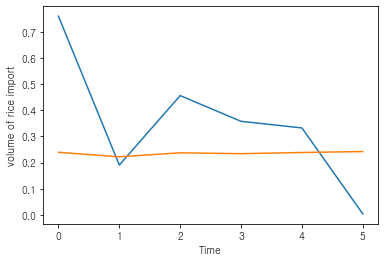

In [53]:
plt.plot(test_rice_Y)
plt.plot(test_predict)
plt.xlabel('Time')
plt.ylabel('volume of rice import')
plt.show()